# Task 5: Strategy Backtesting

## Objective
Validate the optimized portfolio from Task 4 by simulating its performance on historical data and comparing it against a simple benchmark portfolio.

> Prerequisite: Run Tasks 1–4 first so that processed returns and optimized portfolio weights are available.

In [1]:
# 1. Imports and configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully for Task 5.")

Libraries imported successfully for Task 5.


In [2]:
# 2. Load historical returns

# Load processed data
tsla_data = pd.read_csv('../data/processed/TSLA_processed.csv', index_col='Date', parse_dates=True)
bnd_data  = pd.read_csv('../data/processed/BND_processed.csv',  index_col='Date', parse_dates=True)
spy_data  = pd.read_csv('../data/processed/SPY_processed.csv',  index_col='Date', parse_dates=True)

# Ensure daily returns columns exist
for df in [tsla_data, bnd_data, spy_data]:
    if 'Daily_Return' not in df.columns:
        df['Daily_Return'] = df['Adj Close'].pct_change()

returns_hist = pd.DataFrame({
    'TSLA': tsla_data['Daily_Return'],
    'BND':  bnd_data['Daily_Return'],
    'SPY':  spy_data['Daily_Return']
}).dropna()

print("Historical daily returns shape:", returns_hist.shape)

Historical daily returns shape: (2774, 3)


## 3. Define Backtesting Period, Strategy, and Benchmark

- **Backtest Window**: Use the last year of the dataset (e.g., 2025-01-01 to 2026-01-15).
- **Strategy Portfolio**: Use the optimized portfolio from Task 4 (e.g., Maximum Sharpe Ratio weights).
- **Benchmark Portfolio**: Static 60% SPY / 40% BND portfolio (common balanced benchmark).

In [7]:
# 3.1 Backtest window and portfolio weights

backtest_start = '2025-01-01'
backtest_end   = '2026-01-15'

# Build timezone-safe boolean mask using a UTC-converted index (robust to tz-aware/naive mixes)
idx_utc = pd.to_datetime(returns_hist.index, utc=True)
start_ts = pd.to_datetime(backtest_start)
end_ts = pd.to_datetime(backtest_end)
# Ensure start/end are UTC-aware
if start_ts.tz is None:
    start_utc = start_ts.tz_localize('UTC')
else:
    start_utc = start_ts.tz_convert('UTC')
if end_ts.tz is None:
    end_utc = end_ts.tz_localize('UTC')
else:
    end_utc = end_ts.tz_convert('UTC')
# Boolean mask and positional slice (use iloc with boolean ndarray)
mask = (idx_utc >= start_utc) & (idx_utc <= end_utc)
bt_returns = returns_hist.iloc[mask].copy()
print("Backtest period shape:", bt_returns.shape)

# === IMPORTANT ===
# Manually set these weights based on Task 4 output.
# After you run Task 4 and see the printed Max Sharpe weights, paste them here.

# Example placeholder (replace with your actual weights from Task 4):
strategy_weights = np.array([
    0.40,  # TSLA weight (example)
    0.30,  # BND weight (example)
    0.30   # SPY weight (example)
])

# Benchmark: 60% SPY / 40% BND
benchmark_weights = np.array([
    0.0,  # TSLA
    0.4,  # BND
    0.6   # SPY
])

print("Strategy weights (TSLA, BND, SPY):", strategy_weights)
print("Benchmark weights (TSLA, BND, SPY):", benchmark_weights)

Backtest period shape: (259, 3)
Strategy weights (TSLA, BND, SPY): [0.4 0.3 0.3]
Benchmark weights (TSLA, BND, SPY): [0.  0.4 0.6]


In [8]:
# 4. Simulate Daily Portfolio Returns

R = bt_returns[['TSLA', 'BND', 'SPY']].values

strategy_port_ret  = R @ strategy_weights
benchmark_port_ret = R @ benchmark_weights

strategy_port_ret  = pd.Series(strategy_port_ret, index=bt_returns.index, name='Strategy')
benchmark_port_ret = pd.Series(benchmark_port_ret, index=bt_returns.index, name='Benchmark')

print("First few strategy returns:")
display(strategy_port_ret.head())

First few strategy returns:


Date
2025-01-02 00:00:00-05:00   -0.024938
2025-01-03 00:00:00-05:00    0.036238
2025-01-06 00:00:00-05:00    0.002030
2025-01-07 00:00:00-05:00   -0.020677
2025-01-08 00:00:00-05:00    0.001362
Name: Strategy, dtype: float64

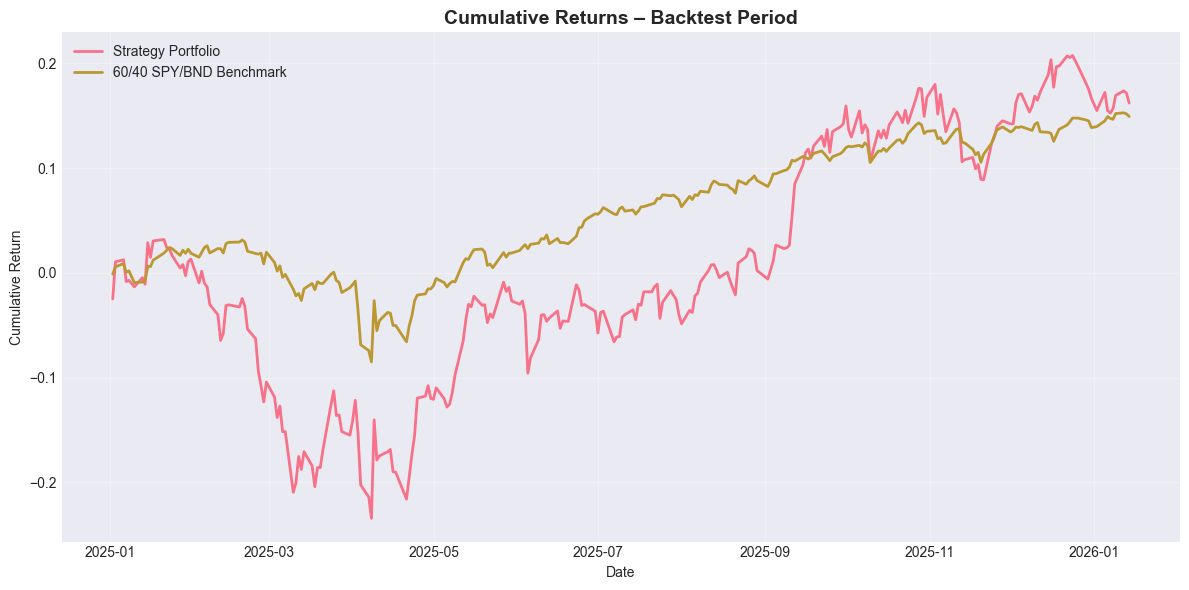

Performance metrics:


,Portfolio,Total Return,Annualized Return,Sharpe Ratio,Max Drawdown
0,Strategy,0.162030,0.207788,0.638612,-0.258109
1,Benchmark,0.149208,0.152798,1.125718,-0.112888


In [9]:
# 5. Cumulative Returns and Performance Metrics

def cumulative_returns(r):
    return (1 + r).cumprod() - 1

def annualized_return(r, periods_per_year=252):
    mean_daily = r.mean()
    return (1 + mean_daily) ** periods_per_year - 1

def sharpe_ratio(r, risk_free=0.02, periods_per_year=252):
    ann_ret = annualized_return(r, periods_per_year)
    ann_vol = r.std() * np.sqrt(periods_per_year)
    return (ann_ret - risk_free) / ann_vol

def max_drawdown(r):
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    drawdown = (cum - peak) / peak
    return drawdown.min()

# Cumulative returns
strategy_cum  = cumulative_returns(strategy_port_ret)
benchmark_cum = cumulative_returns(benchmark_port_ret)

plt.figure(figsize=(12, 6))
plt.plot(strategy_cum.index, strategy_cum.values, label='Strategy Portfolio', linewidth=2)
plt.plot(benchmark_cum.index, benchmark_cum.values, label='60/40 SPY/BND Benchmark', linewidth=2)
plt.title('Cumulative Returns – Backtest Period', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../data/processed/task5_cumulative_returns.png', dpi=300, bbox_inches='tight')
plt.show()

# Metrics table
metrics = []
for name, r in [('Strategy', strategy_port_ret), ('Benchmark', benchmark_port_ret)]:
    metrics.append({
        'Portfolio':          name,
        'Total Return':       cumulative_returns(r).iloc[-1],
        'Annualized Return':  annualized_return(r),
        'Sharpe Ratio':       sharpe_ratio(r),
        'Max Drawdown':       max_drawdown(r)
    })

metrics_df = pd.DataFrame(metrics)
print("Performance metrics:")
display(metrics_df)